In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv('期权相关数据（原始数据）.csv',sep=',')
columns = ['日期',' 50etf收盘价 ', ' 成交量pcr ',' 持仓量pcr ',' 持仓额pcr ',' 成交额pcr/成交量pcr ',' VIX ', ' SKEW ']
df = df[columns].dropna()
df.tail()

/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,日期,50etf收盘价,成交量pcr,持仓量pcr,持仓额pcr,成交额pcr/成交量pcr,VIX,SKEW
1723,2022/03/11,2.922,0.95,0.55,2.75,2.03,22.19,97.96
1724,2022/03/14,2.832,1.03,0.51,5.14,1.97,24.92,94.36
1725,2022/03/15,2.687,0.97,0.43,9.69,3.47,25.97,80.04
1726,2022/03/16,2.810,0.83,0.48,3.31,2.03,26.92,100.45
1727,2022/03/17,2.857,0.76,0.57,2.59,1.11,25.55,103.29


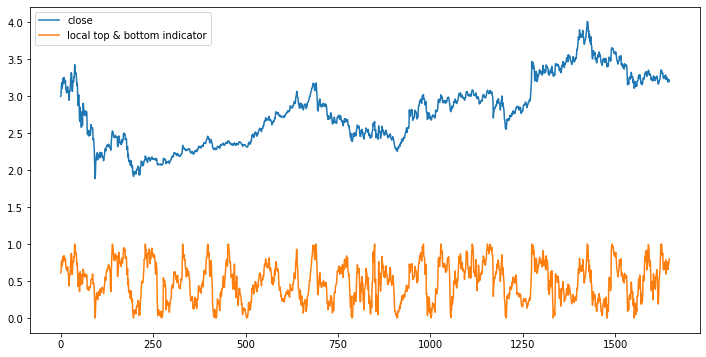

In [3]:
# local top or bottom is searched in a window with width '2*<window>+1'
window = 40

# data features are all the columns of the current day and the previous <window> days
X_raw = df[columns[1:]].to_numpy()
X = np.array([X_raw[i-window:i+1,:].flatten('F') for i in range(window, X_raw.shape[0]-window-1)])

# labels are the relative value comparing to the local maximum and local minimum
close = df[columns[1]].to_numpy()
y = np.zeros(close.shape[0]-window*2-1)
for i in range(window, close.shape[0]-window-1):
    loc_max = np.max(close[i-window:i+window+1])
    loc_min = np.min(close[i-window:i+window+1])
    y[i-window] = (close[i] - loc_min)/(loc_max - loc_min)


plt.figure(figsize = (12,6))    
plt.plot(X[:,window])
plt.plot(y)
plt.legend(['close', 'local top & bottom indicator'])

In [4]:
# prepare training and test dataset
X_train = X[:int(X.shape[0]*.8), :]
y_train = y[:int(X.shape[0]*.8)]
X_test = X[int(X.shape[0]*.8):, :]
y_test = y[int(X.shape[0]*.8):]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1317, 287) (1317,) (330, 287) (330,)


In [5]:
# train a SVR regressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# prepare a std scaler and trained on training dataset
scaler = StandardScaler()
scaler.fit(X_train)

regr = SVR(C=.2, epsilon=0.2, kernel='linear')
regr.fit(scaler.transform(X_train), y_train)
y_train_pred = regr.predict(scaler.transform(X_train))
y_test_pred = regr.predict(scaler.transform(X_test))

0.023699600421858667
0.06021673951957613


Text(0.5, 1.0, 'strategery')

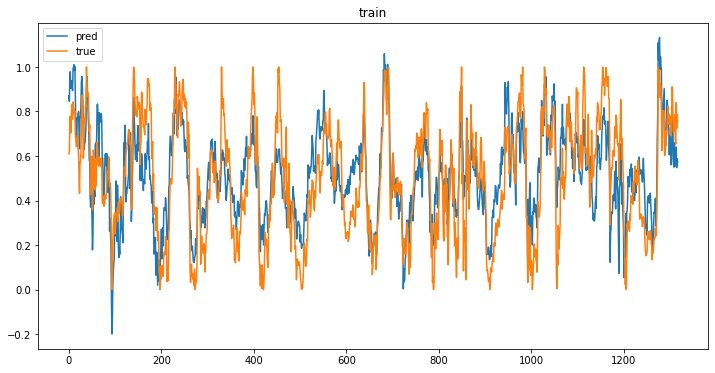

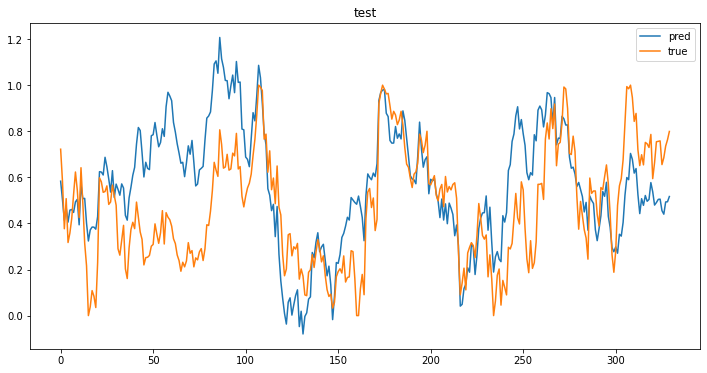

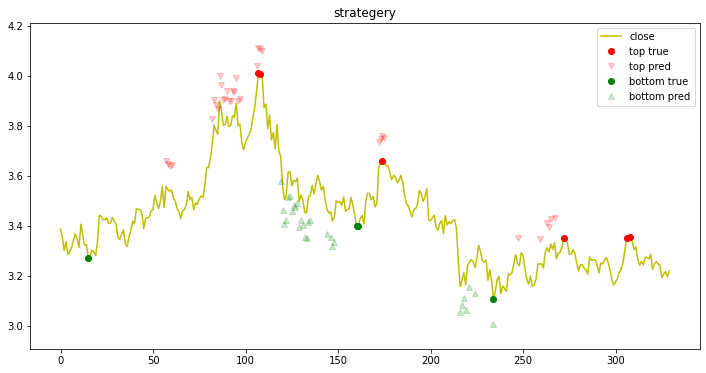

In [6]:
# traning MSE
plt.figure(figsize = (12,6)) 
plt.plot(y_train_pred)
plt.plot(y_train)
plt.legend(['pred', 'true'])
plt.title('train')
print(mean_squared_error(y_train, y_train_pred))

# test MSE
plt.figure(figsize = (12,6))  
plt.plot(y_test_pred)
plt.plot(y_test)
plt.legend(['pred', 'true'])
plt.title('test')
print(mean_squared_error(y_test, y_test_pred))

# strategery
threshold = [.2, .9]
plt.figure(figsize = (12,6))  
plt.plot(X_test[:,window], 'y')
top_pred = y_test_pred > threshold[1]
bottom_pred = y_test_pred < threshold[0]
top_true = (y_test > .99)
bottom_true = (y_test < 0.01)
plt.plot(top_true*X_test[:,window], 'ro')
plt.plot(top_pred*X_test[:,window]+.1, alpha=.2, color='red', marker='v', ls='None')
plt.plot(bottom_true*X_test[:,window], 'go')
plt.plot(bottom_pred*X_test[:,window]-.1, alpha=.2, color='green', marker='^', ls='None')
plt.ylim([np.min(X_test[:,window])-.2, np.max(X_test[:,window])+.2])
plt.legend(['close', 'top true', 'top pred', 'bottom true', 'bottom pred'])
plt.title('strategery')